In [10]:
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import weight_norm



class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

Training CNN model...
CNN - Epoch [100/1000], Loss: 0.0075
CNN - Epoch [200/1000], Loss: 0.0075
CNN - Epoch [300/1000], Loss: 0.0075
CNN - Epoch [400/1000], Loss: 0.0074
CNN - Epoch [500/1000], Loss: 0.0075
CNN - Epoch [600/1000], Loss: 0.0074
CNN - Epoch [700/1000], Loss: 0.0074
CNN - Epoch [800/1000], Loss: 0.0074
CNN - Epoch [900/1000], Loss: 0.0074
CNN - Epoch [1000/1000], Loss: 0.0074

Training TCN model...
TCN - Epoch [100/1000], Loss: 0.0482
TCN - Epoch [200/1000], Loss: 0.0448
TCN - Epoch [300/1000], Loss: 0.0184
TCN - Epoch [400/1000], Loss: 0.0318
TCN - Epoch [500/1000], Loss: 0.0209
TCN - Epoch [600/1000], Loss: 0.0182
TCN - Epoch [700/1000], Loss: 0.0129
TCN - Epoch [800/1000], Loss: 0.0291
TCN - Epoch [900/1000], Loss: 0.0138
TCN - Epoch [1000/1000], Loss: 0.0099

Model Evaluation Results:
CNN - MSE: 1.8988, MAE: 1.2501
TCN - MSE: 0.6030, MAE: 0.5999


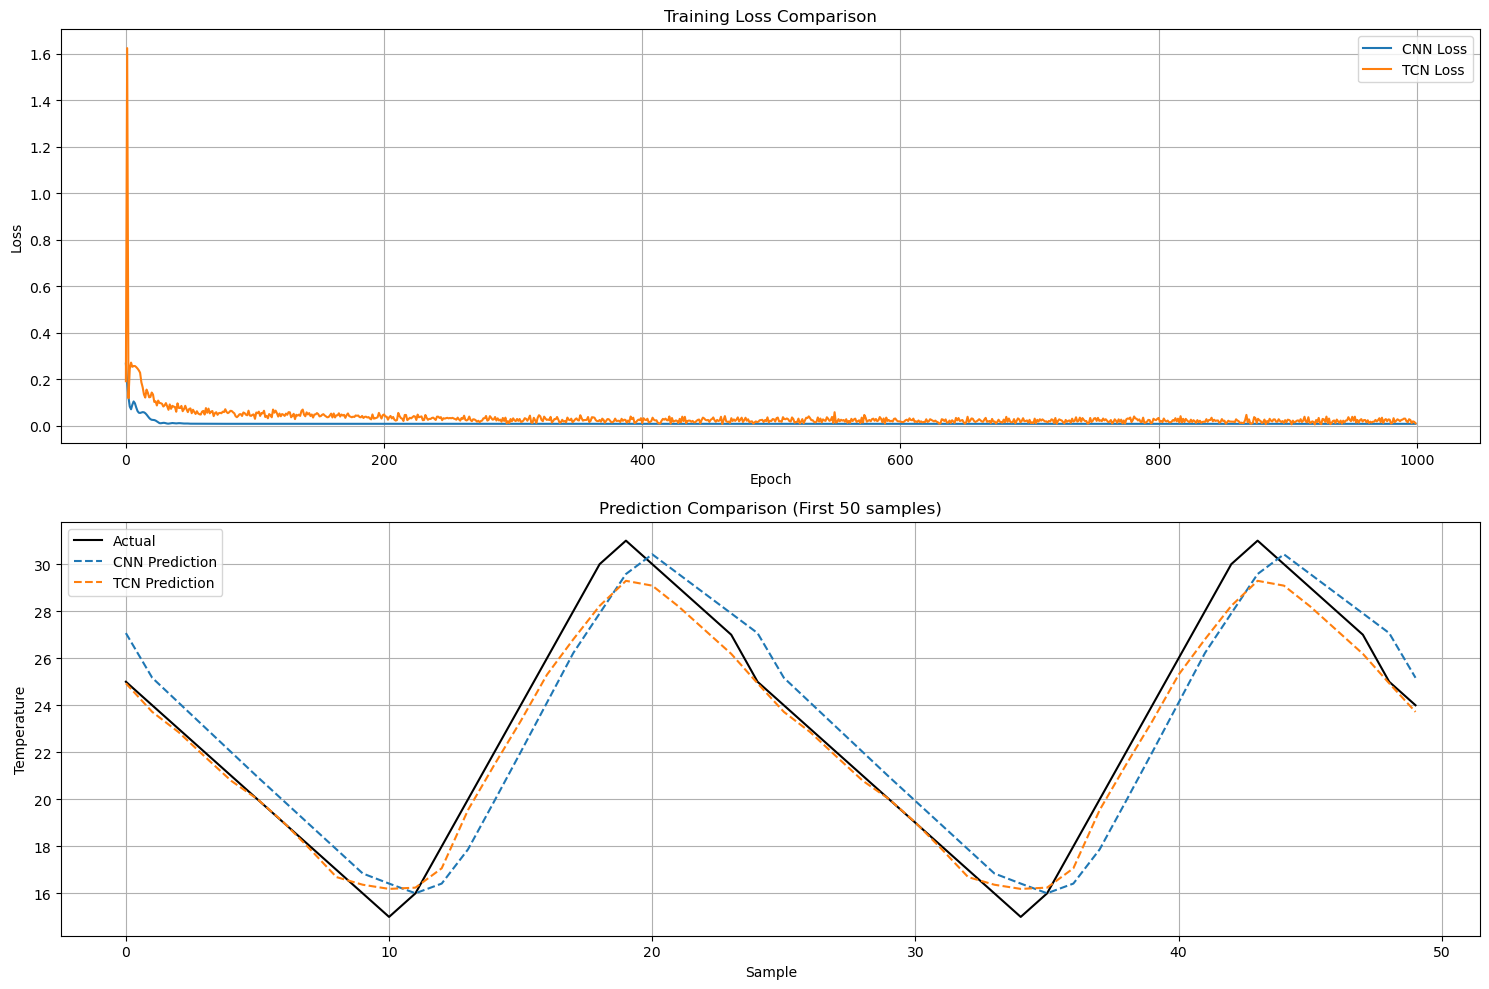

In [11]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# 定义CNN模型
class TimeSeriesCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=32, kernel_size=3):
        super(TimeSeriesCNN, self).__init__()
        
        # 保持与TCN相似的层数和通道数
        self.network = nn.Sequential(
            nn.Conv1d(input_channels, hidden_channels, kernel_size, padding=kernel_size-1),
            nn.ReLU(),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size, padding=kernel_size-1),
            nn.ReLU(),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size, padding=kernel_size-1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.network(x)

# 准备数据（与之前相同）
def prepare_data():
    hours_per_day = 24
    n_days = 7
    temperatures = np.array([
        25, 24, 23, 22, 21, 20, 19, 18,  # 凌晨
        17, 16, 15, 16, 18, 20, 22, 24,  # 上午
        26, 28, 30, 31, 30, 29, 28, 27   # 下午到晚上
    ] * 7)  # 重复7天
    
    # 归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    temperatures_normalized = scaler.fit_transform(temperatures.reshape(-1, 1)).flatten()
    
    # 创建序列
    sequences = []
    targets = []
    sequence_length = 24
    
    for i in range(len(temperatures_normalized) - sequence_length - 1):
        sequence = temperatures_normalized[i:i + sequence_length]
        target = temperatures_normalized[i + sequence_length]
        sequences.append(sequence)
        targets.append(target)
        
    X = np.array(sequences)
    y = np.array(targets)
    
    # 转换为PyTorch张量
    X_tensor = torch.FloatTensor(X).unsqueeze(1)  # [batch_size, channels, sequence_length]
    y_tensor = torch.FloatTensor(y)
    
    return X_tensor, y_tensor, scaler

# 训练函数
def train_model(model, X_tensor, y_tensor, model_name, n_epochs=500):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    losses = []
    
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        predictions = outputs[:, -1, -1]  # 取最后一个时间步的预测值
        
        loss = criterion(predictions, y_tensor)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'{model_name} - Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')
            
    return losses

# 评估函数
def evaluate_model(model, X_tensor, y_tensor, scaler):
    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor)
        predicted_values = predictions[:, -1, -1].numpy()
        
        # 反归一化
        predicted_temps = scaler.inverse_transform(predicted_values.reshape(-1, 1)).flatten()
        actual_temps = scaler.inverse_transform(y_tensor.numpy().reshape(-1, 1)).flatten()
        
        # 计算评估指标
        mse = np.mean((predicted_temps - actual_temps) ** 2)
        mae = np.mean(np.abs(predicted_temps - actual_temps))
        
        return predicted_temps, actual_temps, mse, mae

# 主程序
def main():
    # 准备数据
    X_tensor, y_tensor, scaler = prepare_data()
    
    # 初始化模型
    cnn_model = TimeSeriesCNN()
    tcn_model = TemporalConvNet(
        num_inputs=1,
        num_channels=[32, 32, 32],
        kernel_size=3
    )
    
    # 训练模型
    print("Training CNN model...")
    cnn_losses = train_model(cnn_model, X_tensor, y_tensor, "CNN")
    
    print("\nTraining TCN model...")
    tcn_losses = train_model(tcn_model, X_tensor, y_tensor, "TCN")
    
    # 评估模型
    cnn_pred, cnn_actual, cnn_mse, cnn_mae = evaluate_model(cnn_model, X_tensor, y_tensor, scaler)
    tcn_pred, tcn_actual, tcn_mse, tcn_mae = evaluate_model(tcn_model, X_tensor, y_tensor, scaler)
    
    # 打印评估结果
    print("\nModel Evaluation Results:")
    print(f"CNN - MSE: {cnn_mse:.4f}, MAE: {cnn_mae:.4f}")
    print(f"TCN - MSE: {tcn_mse:.4f}, MAE: {tcn_mae:.4f}")
    
    # 可视化结果
    plt.figure(figsize=(15, 10))
    
    # 训练损失对比
    plt.subplot(2, 1, 1)
    plt.plot(cnn_losses, label='CNN Loss')
    plt.plot(tcn_losses, label='TCN Loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # 预测结果对比
    plt.subplot(2, 1, 2)
    plt.plot(cnn_actual[:50], label='Actual', color='black')
    plt.plot(cnn_pred[:50], label='CNN Prediction', linestyle='--')
    plt.plot(tcn_pred[:50], label='TCN Prediction', linestyle='--')
    plt.title('Prediction Comparison (First 50 samples)')
    plt.xlabel('Sample')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()